# Sieci Bayesa w kontekście przewidywania toksyczności związków chemicznych (cz. 1)

## Karol Baran

W tym notatniku wykonano badania dotyczące modelu przewidującego wartość pojedynczej zmiennej w zadaniu klasyfikacji binarnej z użyciem algorytmu sieci Bayesowskich (ang. Bayesian Belief Networks, BBN).



Import bibliotek

In [16]:
%%capture
#BAYES
! pip install bnlearn
#RDKIT
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

Import danych z pliku bazodanego sdf

In [45]:
from rdkit.Chem import PandasTools
import pandas as pd
import os
from rdkit import RDConfig

sdfFile = os.path.join(RDConfig.RDDataDir,'/content/drive/MyDrive/bayes-konf-06-22/tox21.sdf') 
frame = PandasTools.LoadSDF(sdfFile, smilesName='SMILES', molColName='Molecule',
           includeFingerprints=True)
print(frame.columns)
print(frame.shape)

RDKit ERROR: [20:38:27] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Invariant Violation
RDKit ERROR: no eligible neighbors for chiral center
RDKit ERROR: Violation occurred on line 215 in file /opt/conda/conda-bld/rdkit_1603173682698/work/Code/GraphMol/FileParsers/MolFileStereochem.cpp
RDKit ERROR: Failed Expression: nbrScores.size()
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [20:40:45] Explicit valence for atom # 2 Si, 8, is greater than permitted
RDKit ERROR: [20:40:45] ERROR: Could not sanitize molecule ending on line 346021
RDKit WARNING: [20:40:51] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [20:40:45] ERROR: Explicit valence for atom # 2 Si, 8, is greater than permitted
RDKit ERROR: [20:40:53] Explicit valence for atom # 2 Si, 8, is greater than permitted
RDKit ERROR: [20:40:53] ERROR: Could not sanitize molecule ending on line 810094
RDKit ERROR: [20:40:53] ERROR: Explicit valence for atom # 2 Si, 8, is greater than permitted
RDKit ERROR: [20:40:55] Ex

Index(['Formula', 'FW', 'DSSTox_CID', 'SR-HSE', 'ID', 'SMILES', 'Molecule',
       'NR-AR', 'SR-ARE', 'NR-Aromatase', 'NR-ER-LBD', 'NR-AhR', 'SR-MMP',
       'NR-ER', 'NR-PPAR-gamma', 'SR-p53', 'SR-ATAD5', 'NR-AR-LBD'],
      dtype='object')
(11761, 18)


Wyznaczenie deskryptorów

In [46]:
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import numpy as np

nBITS = 1024
fps = []
moldclist = []
for index, row in frame.iterrows():
  moldc = {}
  fp = AllChem.GetMorganFingerprintAsBitVect(row['Molecule'],4,nBits=nBITS,bitInfo=moldc)
  arr = np.zeros((0,), dtype=np.int8)
  DataStructs.ConvertToNumpyArray(fp,arr)
  fps.append(arr)
  moldclist.append(moldc)

Wstępne oczyszczenie danych

In [47]:
features_tox = 'NR-AR' # NR-AR, NR-AR-LBD
data = pd.concat([frame[features_tox], pd.DataFrame(fps)], axis=1)
data.dropna(subset=range(0,nBITS), how='any', inplace=True)
print(data.columns)
print(data.shape)

Index(['NR-AR',       0,       1,       2,       3,       4,       5,       6,
             7,       8,
       ...
          1014,    1015,    1016,    1017,    1018,    1019,    1020,    1021,
          1022,    1023],
      dtype='object', length=1025)
(11761, 1025)


In [48]:
import bnlearn as bn

data_cur = data.dropna()

Wybór istotnych zmiennych z użyciem kryterium entropii

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, SelectFromModel, mutual_info_classif, f_classif, chi2, RFE, SelectFpr
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.utils import resample

df_0 = data_cur[data_cur[features_tox] != '1']
df_1 = data_cur[data_cur[features_tox] == '1']  
df_0_down = resample(df_0,random_state=42,n_samples=len(df_1),replace=True)
data_down_cur = pd.concat([df_0_down,df_1])

X_train, X_test, y_train, y_test = train_test_split(data_down_cur.drop(features_tox, axis=1), data_down_cur[features_tox], test_size=0.2)

select_fea = SelectKBest(k=5,
                         score_func=mutual_info_classif,
                         ).fit(X_train, y_train)
X_train = select_fea.transform(X_train)
selected_fea = select_fea.get_feature_names_out()
selected_fea = [e[1:] for e in selected_fea]
print(selected_fea)

['138', '182', '301', '519', '1019']


Walidacja krzyżowa

In [50]:
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from statistics import mean

dfx, dft = pd.DataFrame(X_train), pd.DataFrame(y_train)
dft.index = dfx.index
train = pd.concat([dfx, dft], axis=1)
train.columns = [*selected_fea, features_tox]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
DAG = bn.structure_learning.fit(train, 
                                methodtype='hc', 
                                )

used_params = list({item for sublist in DAG['model_edges'] for item in sublist})
train = train.loc[:, used_params]

acc, bac, auc, pre, rec = [], [], [], [], []
for train_index, test_index in kf.split(train):
  DAGp = bn.parameter_learning.fit(DAG, train.loc[train_index, :])
  Pout = bn.predict(DAGp, train.loc[test_index, :], variables=features_tox)
  y_pred = Pout[features_tox]
  acc.append(round(accuracy_score(train.loc[test_index, features_tox].astype(int), y_pred), 4))
  bac.append(round(balanced_accuracy_score(train.loc[test_index, features_tox].astype(int), y_pred), 4))
  auc.append(round(roc_auc_score(train.loc[test_index, features_tox].astype(int), y_pred), 4))
  pre.append(round(precision_score(train.loc[test_index, features_tox].astype(int), y_pred), 4))
  rec.append(round(recall_score(train.loc[test_index, features_tox].astype(int), y_pred), 4))

print(f'''
ACC: {acc}, mean: {round(mean(acc), 4)}
BAC: {bac}, mean: {round(mean(bac), 4)}
AUC: {auc}, mean: {round(mean(auc), 4)}
PRE: {pre}, mean: {round(mean(pre), 4)}
REC: {rec}, mean: {round(mean(rec), 4)}
''')

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 138:
+----------+---------------------+--------------------+
| 301      | 301(0.0)            | 301(1.0)           |
+----------+---------------------+--------------------+
| 138(0.0) | 0.6922169811320755  | 0.4670846394984326 |
+----------+---------------------+--------------------+
| 138(1.0) | 0.30778301886792453 | 0.5329153605015674 |
+----------+---------------------+--------------------+
[bnlearn] >CPD of 182:
+----------+---------------------+-----+---------------------+
| 138      | 138(0.0)            | ... | 138(1.0)            |
+----------+---------------------+-----+---------------------+
| 301      | 301(0.0)            | ... | 301(1.0)            |
+----------+---------------------+-----+---------------------+
| 519      | 519(0.0)            | ... | 519(1.0)  

100%|██████████| 9/9 [00:00<00:00, 49.65it/s]


[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 138:
+----------+--------------------+-------------------+
| 301      | 301(0.0)           | 301(1.0)          |
+----------+--------------------+-------------------+
| 138(0.0) | 0.6964705882352941 | 0.470125786163522 |
+----------+--------------------+-------------------+
| 138(1.0) | 0.3035294117647059 | 0.529874213836478 |
+----------+--------------------+-------------------+
[bnlearn] >CPD of 182:
+----------+---------------------+-----+---------------------+
| 138      | 138(0.0)            | ... | 138(1.0)            |
+----------+---------------------+-----+---------------------+
| 301      | 301(0.0)            | ... | 301(1.0)            |
+----------+---------------------+-----+---------------------+
| 519      | 519(0.0)            | ... | 519(1.0)            |
+----------+---------------------+-----+---------------------+
| 182(0.0) | 0.85

100%|██████████| 14/14 [00:00<00:00, 50.36it/s]


[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 138:
+----------+---------------------+---------------------+
| 301      | 301(0.0)            | 301(1.0)            |
+----------+---------------------+---------------------+
| 138(0.0) | 0.6964078794901506  | 0.46869983948635635 |
+----------+---------------------+---------------------+
| 138(1.0) | 0.30359212050984935 | 0.5313001605136437  |
+----------+---------------------+---------------------+
[bnlearn] >CPD of 182:
+----------+---------------------+-----+---------------------+
| 138      | 138(0.0)            | ... | 138(1.0)            |
+----------+---------------------+-----+---------------------+
| 301      | 301(0.0)            | ... | 301(1.0)            |
+----------+---------------------+-----+---------------------+
| 519      | 519(0.0)            | ... | 519(1.0)            |
+----------+---------------------+-----+-------------------

100%|██████████| 12/12 [00:00<00:00, 51.45it/s]


[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 138:
+----------+---------------------+---------------------+
| 301      | 301(0.0)            | 301(1.0)            |
+----------+---------------------+---------------------+
| 138(0.0) | 0.6925795053003534  | 0.47492163009404387 |
+----------+---------------------+---------------------+
| 138(1.0) | 0.30742049469964666 | 0.5250783699059561  |
+----------+---------------------+---------------------+
[bnlearn] >CPD of 182:
+----------+---------------------+-----+---------------------+
| 138      | 138(0.0)            | ... | 138(1.0)            |
+----------+---------------------+-----+---------------------+
| 301      | 301(0.0)            | ... | 301(1.0)            |
+----------+---------------------+-----+---------------------+
| 519      | 519(0.0)            | ... | 519(1.0)            |
+----------+---------------------+-----+-------------------

100%|██████████| 13/13 [00:00<00:00, 53.16it/s]


[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 138:
+----------+--------------------+--------------------+
| 301      | 301(0.0)           | 301(1.0)           |
+----------+--------------------+--------------------+
| 138(0.0) | 0.6941176470588235 | 0.4740973312401884 |
+----------+--------------------+--------------------+
| 138(1.0) | 0.3058823529411765 | 0.5259026687598116 |
+----------+--------------------+--------------------+
[bnlearn] >CPD of 182:
+----------+---------------------+-----+--------------------+
| 138      | 138(0.0)            | ... | 138(1.0)           |
+----------+---------------------+-----+--------------------+
| 301      | 301(0.0)            | ... | 301(1.0)           |
+----------+---------------------+-----+--------------------+
| 519      | 519(0.0)            | ... | 519(1.0)           |
+----------+---------------------+-----+--------------------+
| 182(0.0) | 0.84

100%|██████████| 12/12 [00:00<00:00, 52.89it/s]


ACC: [0.6557, 0.6885, 0.6967, 0.719, 0.6281], mean: 0.6776
BAC: [0.6975, 0.6885, 0.726, 0.7123, 0.6422], mean: 0.6933
AUC: [0.6975, 0.6885, 0.726, 0.7123, 0.6422], mean: 0.6933
PRE: [0.9667, 0.96, 0.9697, 0.963, 0.95], mean: 0.9619
REC: [0.4143, 0.3934, 0.4706, 0.4407, 0.3016], mean: 0.4041



Ocena na zbiorze testowym

In [51]:
if features_tox in used_params: used_params.remove(features_tox)
X_test_prep = X_test.loc[:, map(int, used_params)]
X_test_prep.columns = used_params
DAGp = bn.parameter_learning.fit(DAG, train)
Pout = bn.predict(DAGp, X_test_prep, variables=features_tox)
print(Pout)

y_pred = Pout[features_tox]
print(f'ACC: {accuracy_score(y_test.astype(int), y_pred):.4f}')
print(f'BAC: {balanced_accuracy_score(y_test.astype(int), y_pred):.4f}')
print(f'AUC: {roc_auc_score(y_test.astype(int), y_pred):.4f}')
print(f'PRE: {precision_score(y_test.astype(int), y_pred):.4f}')
print(f'REC: {recall_score(y_test.astype(int), y_pred):.4f}')

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 138:
+----------+--------------------+--------------------+
| 301      | 301(0.0)           | 301(1.0)           |
+----------+--------------------+--------------------+
| 138(0.0) | 0.7202127659574468 | 0.4655688622754491 |
+----------+--------------------+--------------------+
| 138(1.0) | 0.2797872340425532 | 0.5344311377245509 |
+----------+--------------------+--------------------+
[bnlearn] >CPD of 182:
+----------+---------------------+-----+--------------------+----------+
| 138      | 138(0.0)            | ... | 138(1.0)           | 138(1.0) |
+----------+---------------------+-----+--------------------+----------+
| 301      | 301(0.0)            | ... | 301(1.0)           | 301(1.0) |
+----------+---------------------+-----+--------------------+----------+
| 519      | 519(0.0)            | ... | 519(0.0)           | 519(1.0) |
+----------+-

100%|██████████| 15/15 [00:00<00:00, 49.83it/s]


     NR-AR         p
0        1  0.662338
1        0  0.565495
2        0  0.565495
3        0  0.565495
4        0  0.508721
..     ...       ...
147      1  0.662338
148      0  0.565495
149      0  0.565495
150      0  0.565495
151      0  0.565495

[152 rows x 2 columns]
ACC: 0.7697
BAC: 0.7034
AUC: 0.7034
PRE: 1.0000
REC: 0.4068


Rysunek sieci

[bnlearn]> Set node properties.
[bnlearn]> Set edge properties.
[bnlearn] >Plot based on Bayesian model


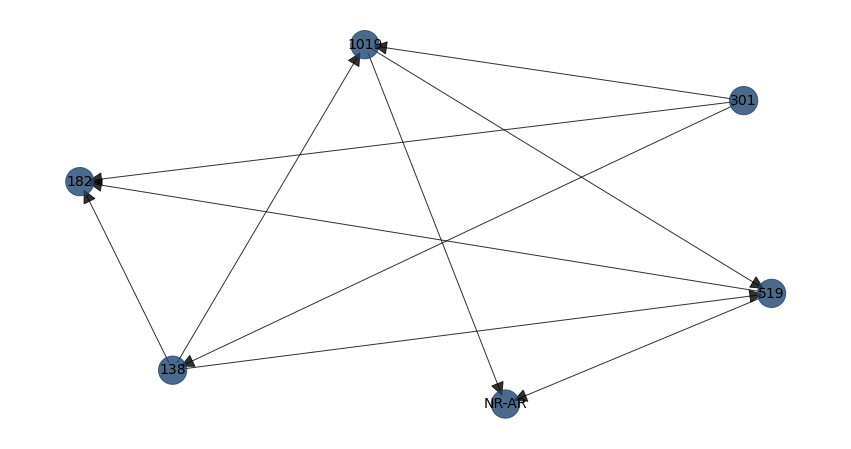

In [52]:
G = bn.plot(DAGp, interactive=False, ) #plot